#    For the problem -u''+ alpha_omega* u = f_omega
#    B = BilinearForm(fes_state) = grad(u) * grad(v) * dx  + alpha_omega*u*v *dx
based on Newton_Topo_Try2

In [1]:
import numpy as np
import netgen.geom2d as geom2d
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry  # SplieGeometry to define a 2D mesh
from ngsolve.internal import *
from interpolations import InterpolateLevelSetToElems # function which interpolates a levelset function
from scipy.sparse import csr_matrix  # Assuming M.mat and D.mat are CSR sparse matrices
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import splu
myMAXH = 0.1

EPS = myMAXH * 1e-6      #variable defining when a point is on the interface and when not

geo = SplineGeometry()

R = 2

## add a rectangle
geo.AddRectangle(p1=(-R,-R),
                 p2=(R,R),
                 bc="rectangle",
                 leftdomain=1,
                 rightdomain=0)
geo.SetMaterial (1, "outer") # give the domain the name "outer"
mesh = Mesh(geo.GenerateMesh(maxh=myMAXH)) # generate ngsolve mesh


fes_state = H1(mesh, order=1)
fes_adj = H1(mesh, order=1)
fes_level = H1(mesh, order=1)

pwc = L2(mesh)   #piecewise constant space

N = fes_state.ndof

## test and trial functions
u, v = fes_state.TnT()

p, q = fes_adj.TnT()

gfu = GridFunction(fes_state)
gfp = GridFunction(fes_adj)

gfU = GridFunction(fes_state)
gfP = GridFunction(fes_adj)

gfDU = GridFunction(fes_state)
gfDP = GridFunction(fes_adj)

gfud = GridFunction(fes_state)

psi = GridFunction(fes_level)
psi.Set(-1)

psides = GridFunction(fes_level)
psinew = GridFunction(fes_level)

# ell=1e-3
# vol = GridFunction(pwc)
# InterpolateLevelSetToElems(psi, 1, 0, vol, mesh, EPS)
# vol_term = ell*(Integrate(vol,mesh))**2


print("Degrees of freedom =",N)
# print(vol_term)

Degrees of freedom = 1942


In [2]:
 #Forms And Solver

f1 = 10
f2 = 1
alpha1 = 1
alpha2 = 1

f_rhs = GridFunction(pwc)
f_rhs.Set(f1)
alpha = GridFunction(pwc)
alpha.Set(alpha1)

# bilinear form for state 
B = BilinearForm(fes_state)
B += grad(u) * grad(v) * dx
B += alpha*u * v * dx

# bilinear form for adjoint 
B_adj = BilinearForm(fes_adj)
B_adj += grad(p) * grad(q) * dx
B_adj += alpha*p*q*dx


L = LinearForm(fes_state) #Linear form for state
L += f_rhs * v *dx


InterpolateLevelSetToElems(psi, f1, f2, f_rhs, mesh, EPS) # adjust values of RHS according to current PSI
InterpolateLevelSetToElems(psi, alpha1, alpha2, alpha, mesh, EPS) # adjust values of RHS according to current PSI

B.Assemble() #
L.Assemble() # Assemble with the adjusted f_rhs

inv = B.mat.Inverse(inverse="sparsecholesky") # inverse of bilinear form
gfu.vec.data = inv*L.vec
scene_u = Draw(gfu)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

In [3]:

l1,l2 = fes_level.TnT()

eps = 1e-2
B_smooth = BilinearForm(fes_level)
B_smooth += (eps*grad(l1)*grad(l2) + l1*l2)*dx
B_smooth.Assemble()
B_smooth_inv = B_smooth.mat.Inverse(inverse="sparsecholesky")

gg = GridFunction(fes_level)

L_smooth = LinearForm(fes_level)
L_smooth += gg * l2 * dx

direction_smooth = GridFunction(fes_level)



In [4]:

a = 4.0/5.0
b = 2
f = CoefficientFunction( 0.1*( (sqrt((x - a)**2 + b * y**2) - 1) \
                * (sqrt((x + a)**2 + b * y**2) - 1) \
                * (sqrt(b * x**2 + (y - a)**2) - 1) \
                * (sqrt(b * x**2 + (y + a)**2) - 1) - 0.001) )

# solving
psides.Set(f)
InterpolateLevelSetToElems(psides, f1, f2, f_rhs, mesh, EPS)
InterpolateLevelSetToElems(psides, alpha1, alpha2, alpha, mesh, EPS)

B.Assemble()
L.Assemble()
inv = B.mat.Inverse( inverse="sparsecholesky") # inverse of bilinear form

gfud.vec.data = inv*L.vec


Draw(gfud)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [5]:
duL = LinearForm(fes_state)
dpL = LinearForm(fes_adj)


c = 1

# duL += 2*(gfU-gfud+c*10*x*y)*q * dx + (grad(gfP)*grad(q) + gfP*q)*dx
# dpL += (grad(gfU)*grad(v) + gfU*v)*dx - f_rhs*v*dx

def SolvePDE(adjoint=False):
    #Newton(a, gfu, printing = False, maxerr = 3e-9)

    B.Assemble()
    L.Assemble()

    inv_state = B.mat.Inverse(fes_state.FreeDofs(), inverse="sparsecholesky")

    # solve state equation
    gfu.vec.data = inv_state*L.vec
    scene_u.Redraw()
    if adjoint == True:
        # solve adjoint state equatoin
        duCost.Assemble()
        B_adj.Assemble()
        inv_adj = B_adj.mat.Inverse(fes_adj.FreeDofs(), inverse="sparsecholesky")
        gfp.vec.data = -inv_adj * duCost.vec

InterpolateLevelSetToElems(psi, f1, f2, f_rhs, mesh, EPS)
InterpolateLevelSetToElems(psi, alpha1, alpha2, alpha, mesh, EPS)

#Cost/duCost can only be defined after you solve for u and ud

# InterpolateLevelSetToElems(psi, 1, 0, vol, mesh, EPS)
# vol_term = ell*(Integrate(vol,mesh))**2

def Cost(u): 

    return (u - gfud+c*10*x*y )**2*dx 


duCost = LinearForm(fes_adj)
duCost += 2*(gfu-gfud+10*c*x*y) * q * dx 


SolvePDE(adjoint=True)
#print(gfp.vec)
print("initial cost = ", Integrate(Cost(gfu), mesh))
Draw(gfp)



initial cost =  3355.0369878450847


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [6]:
from ngsolve import *
from ngsolve.webgui import Draw
import ipywidgets as widgets
from IPython.display import display
import time
output = widgets.Output()

#####################################################################
DJ=GridFunction(fes_level)
DJ.Set(alpha1-alpha2-(f1-f2)*gfp)
Draw(DJ)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [7]:
#Those matrices are independent from : [ Iteration, Alpha(as it is constant),U,P] 

N = fes_state.ndof
phi1,phi2 = fes_state.TnT()
M = BilinearForm(fes_state)
M += 2*phi1*phi2*dx
# D = BilinearForm(fes_state)
# D += grad(phi1) * grad(phi2) * dx
# D += phi1*phi2*dx

M.Assemble()
# D.Assemble()

M_CSR = M.mat.CSR()
# D_CSR = D.mat.CSR()

M_dense = csr_matrix((M_CSR[0],M_CSR[1],M_CSR[2]),shape=(N, N)).toarray()
# D_dense =  csr_matrix((D_CSR[0],D_CSR[1],D_CSR[2]),shape=(N, N)).toarray()
zer = np.zeros((N, N))



In [8]:
from scipy.sparse.linalg import lsqr
gfU=GridFunction(fes_state)
gfP=GridFunction(fes_adj)
# gfU.vec.data = gfu.vec
# gfP.vec.data = gfp.vec

iter_max = 50
converged = False
direction = GridFunction(fes_state)

nonoptimalpnts = []
itera =[]

kappa = 1
#psi.Set(-1)
xm=0.0
ym=0.0
psi.Set( (x-xm)**2+(y-ym)**2-0.25**2)
#psi.Set(-1)
psinew.vec.data= psi.vec
SolvePDE()
scene_u = Draw(gfu) ##DRAW
scene_psi = Draw(IfPos(psi,1,-1),mesh)
J = Integrate(Cost(gfu),mesh)
print("initial Cost",J)

#FOR SMOOTHING 

direction_smooth = GridFunction(fes_level)

l1,l2 = fes_level.TnT() 

#Smoothing PDE
eps = 5e-3
B_smooth = BilinearForm(fes_level)
B_smooth += (eps*grad(l1)*grad(l2) + l1*l2)*dx
B_smooth.Assemble()
B_smooth_inv = B_smooth.mat.Inverse(inverse="sparsecholesky")

frobenius_norms = []
max_abs_values = []
iterations = []

# BB = np.zeros(3 * N)
# duL = LinearForm(fes_state)
# dpL = LinearForm(fes_adj)
# duL += 2*(gfU-gfud+c*10*x*y)*q * dx + (grad(gfP)*grad(q) + alpha*gfP*q)*dx
# dpL += (grad(gfU)*grad(v) + alpha*gfU*v)*dx - f_rhs*v*dx

with TaskManager():

    for k in range(iter_max):
        print("================ iteration ", k, "===================")
        iterations.append(k)
        # copy new levelset data from psinew into psi
        psi.vec.data = psinew.vec
        scene_psi.Redraw()


    #    scene_u.Redraw()

        InterpolateLevelSetToElems(psi, f1, f2, f_rhs, mesh, EPS)
        InterpolateLevelSetToElems(psi, alpha1, alpha2, alpha, mesh, EPS)

       # InterpolateLevelSetToElems(psi, 1, 0, vol, mesh, EPS)
        #vol_term = ell*(Integrate(vol,mesh))**2
        SolvePDE(True)
        J_current = Integrate(Cost(gfu),mesh) 

        print("cost in beginning of iteration", k, ": Cost = ", J_current)
        
        # RHS
       # BB = np.zeros(3 * N) # Initializing RHS
        indices = [] #For Non optimal points
        A_plus = [] #For Non optimal IN omega
        A_minus = [] #For Non Optimal points OUT omega
        I_plus = []  # for Optimal points IN omega
        I_minus = [] # for Optimal points OUT omega
        BB = np.zeros(3 * N)

        # InterpolateLevelSetToElems(psi, 1, 0, vol, mesh, EPS)
        # vol_term2 = 2*ell*(Integrate(vol,mesh))
        for i in range(N):
            BB[i] = (alpha1-alpha2-f1 + f2) * gfp.vec[i] #- vol_term2 #This expression gives -DJ for x in Omega and DJ for Omega^c
          
            #saving indices in each corresponding set 
            if psi.vec[i] < 0: #In Omega 
               # BB[i]+=vol_term2
                if BB[i] > 0:  #DJ < 0
                    indices.append(i)
                    A_plus.append(i)
                    
                elif BB[i] < 0:#DJ > 0
                    direction.vec[i] = BB[i]
                    I_plus.append(i)
            elif psi.vec[i] > 0: #OUT Omega
              #  BB[i]-=vol_term2
                if BB[i] < 0: #DJ<0
                    indices.append(i)
                    A_minus.append(i)

                elif BB[i] > 0: #DJ>0
                    direction.vec[i] = BB[i]
                    I_minus.append(i)
                   
        nonoptimalpnts.append(len(indices))
        itera.append(k)
        N1 = len(A_plus)
        N2 = len(A_minus)
        N12 = N1+N2
        print("N12=",N12)
        if (N12 < 0.01*N) or (J_current < 0.00001):
            print("99% of elements are optimal" , 100*N12/N ," % = " ,N12,"elements","final cost = ",J_current)
            print(N1,N2)
            break
        zer1 = np.zeros((N1,N1))
        zer2 = np.zeros((N2,N2))
        zer12 = np.zeros((N1,N2))
        zer21 = np.zeros((N2,N1))
        
        # zer1+= ell*np.ones((N1,N1))
        # zer2+= ell*np.ones((N2,N2))

        X_plus = np.zeros((N1,N))
        for i in range(N1):
            X_plus[i][A_plus[i]] = alpha1-alpha2-(f1-f2)
        X_minus = np.zeros((N2,N))
        for i in range(N2):
            X_minus[i][A_minus[i]] = alpha1-alpha2-(f1-f2)

        Y_plus = np.zeros((N1,N))
        Y_minus = np.zeros((N2,N))
        
        D = BilinearForm(fes_state)
        D += grad(phi1) * grad(phi2) * dx
        D += alpha*phi1*phi2*dx
        D.Assemble()
        D_CSR = D.mat.CSR()
        D_dense =  csr_matrix((D_CSR[0],D_CSR[1],D_CSR[2]),shape=(N, N)).toarray()

        block_matrix = np.block([ #Constructing (N1+N2+2N)**2 system
            [zer1,zer12,Y_plus,X_plus],
            [zer21,zer2,Y_minus,X_minus],                   
            [Y_plus.T,Y_minus.T, M_dense, D_dense],
            [X_plus.T,X_minus.T, D_dense.T, zer]
        ])
        print("Matrix Size",block_matrix.shape)
        lower_left_block = block_matrix[N1+N2+N:, :N1+N2]
        frobenius_norm = np.linalg.norm(lower_left_block, 'fro')
        frobenius_norms.append(frobenius_norm)
        
        B_rhs=np.zeros((N1+N2+2*N)) # Inializing RHS

        v = fes_state.TestFunction()
        q = fes_state.TestFunction()
        duL = LinearForm(fes_state)
        dpL = LinearForm(fes_adj)


        # duL += 2*(gfU-gfud+c*10*x*y)*q * dx + (grad(gfP)*grad(q) + alpha*gfP*q)*dx
        # dpL += (grad(gfU)*grad(v) + alpha*gfU*v)*dx - f_rhs*v*dx

        
        # duL += 2*(gfu-gfud+c*10*x*y)*q * dx + (grad(gfp)*grad(q) + alpha*gfp*q)*dx
        # dpL += (grad(gfu)*grad(v) + alpha*gfu*v)*dx - f_rhs*v*dx

        
        duL.Assemble()
        dpL.Assemble()


        #Filling RHS
        # B_rhs[(N1+N2):(N1+N2)+N]= duL.vec.FV().NumPy()[:]
        # B_rhs[(N1+N2)+N:(N1+N2)+2*N] = dpL.vec.FV().NumPy()[:]

        B_rhs[(N1+N2):(N1+N2)+N]= 0
        B_rhs[(N1+N2)+N:(N1+N2)+2*N] = 0
        for indx, i in enumerate(A_plus): #Filling the first N1=len(A_plus) elements of the RHS 
            B_rhs[indx]=BB[i]
        for indx, i in enumerate(A_minus):
            B_rhs[indx + N1]=BB[i]
        
        #Solving 3N system
        A=csr_matrix(block_matrix)
        XX = spsolve(A, -B_rhs) #
        #XX = lsqr(block_matrix,B_rhs)[0] #Gets stuck in an internal infinite loop(probably)
        delta_x = XX[:(N1+N2)]
        delta_u = XX[(N1+N2):((N1+N2)+N)]
        delta_p = XX[((N1+N2)+N):((N1+N2)+2*N)]
        i = 0
        for i in range(N1):
            direction.vec[A_plus[i]]=delta_x[i]
        i = 0
        for i in range(N2):
            direction.vec[A_minus[i]]=delta_x[i+N1]

        #direction.vec.data=delta_x
        
        # norm_direction = sqrt(Integrate(direction**2*dx, mesh)) # L2 norm of TD_node
        # direction.vec.data = 1/norm_direction * direction.vec # normalised TD_node

      # normPsi = sqrt(Integrate(psi**2*dx, mesh)) # L2 norm of psi
        # psi.vec.data = 1/normPsi * psi.vec  # normalised psi

            # update the level set function, solution and adjoint
        # for j in range(3):

        #     # update the level set function
        #     direction_smooth.vec.data = B_smooth_inv*direction.vec #Smoothing
        #     direction.vec.data = direction_smooth.vec
        #     psinew.vec.data = (1-kappa)*psi.vec + kappa*direction.vec #convex combination

        #     InterpolateLevelSetToElems(psinew, f1, f2, f_rhs, mesh, EPS)
        #     InterpolateLevelSetToElems(psinew, alpha1, alpha2, alpha, mesh, EPS)

        #     # solve PDE without adjoint
        #     SolvePDE(True)

        #     Redraw(blocking=True)

        #     Jnew= Integrate(Cost(gfu),mesh)

        #     if Jnew > J_current:
        #         print("-----line search ---")
        #         kappa = kappa*0.8
        #         print("kappa", kappa)
        #     else:
        #         kappa = 1.2*kappa
        #         break

 
        direction_smooth.vec.data = B_smooth_inv*direction.vec #Smoothing
        direction.vec.data = direction_smooth.vec
        psinew.vec.data = (1-kappa)*psi.vec + kappa*direction.vec #convex combination
        
        norm_dir = sqrt(Integrate(direction**2*dx, mesh)) # L2 norm of TD_node
        normPsi = sqrt(Integrate(psi**2*dx, mesh)) # L2 norm of psi        
        arg_arc = Integrate(psi*direction,mesh)/(norm_dir*normPsi)
        theta_k = np.arccos(arg_arc)*180/np.pi
        print("Theta_k =",theta_k,"  degrees")

       # psinew.vec.FV().NumPy()[:] += direction.vec.FV().NumPy()[:]

        gfU.vec.FV().NumPy()[:] += delta_u
        scene_u.Redraw()

        gfP.vec.FV().NumPy()[:] += delta_p

        # print('norm delta u', np.linalg.norm(delta_u))
        # print('norm delta p', np.linalg.norm(delta_p))
        # print('norm dir', np.linalg.norm(direction.vec.FV().NumPy()[:]))

        
        # print('norm dLu', np.linalg.norm(duL.vec.FV().NumPy()[:]))
        # print('norm dLp', np.linalg.norm(dpL.vec.FV().NumPy()[:]))
        # print('norm U', np.linalg.norm(gfU.vec.FV().NumPy()[:]))
        # print('norm P', np.linalg.norm(gfP.vec.FV().NumPy()[:]))

        print("end of iter " + str(k))


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

initial Cost 3355.0369878450856
================ iteration  0 ===================
cost in beginning of iteration 0 : Cost =  3027.2977557805275
N12= 1376
Matrix Size (5260, 5260)
Theta_k = 51.7073201262787   degrees
end of iter 0
================ iteration  1 ===================
cost in beginning of iteration 1 : Cost =  2941.127963491736
N12= 1116
Matrix Size (5000, 5000)
Theta_k = 12.874419105554878   degrees
end of iter 1
================ iteration  2 ===================
cost in beginning of iteration 2 : Cost =  2826.5917744065764
N12= 819
Matrix Size (4703, 4703)
Theta_k = 15.832618099913153   degrees
end of iter 2
================ iteration  3 ===================
cost in beginning of iteration 3 : Cost =  2639.164785149031
N12= 605
Matrix Size (4489, 4489)
Theta_k = 19.721685979468802   degrees
end of iter 3
================ iteration  4 ===================
cost in beginning of iteration 4 : Cost =  2381.443071240631
N12= 335
Matrix Size (4219, 4219)
Theta_k = 22.792363875020364 

In [ ]:
import csv

# Save data to CSV
with open('Non_opt_pnts_ALTERNATIVE.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Iterations', 'Non-Optimal Points'])
    for i in range(len(itera)):
        csvwriter.writerow([itera[i], nonoptimalpnts[i]])

print("Data saved to data.csv")

In [ ]:
import matplotlib.pyplot as plt# Figure 1: Norm vs Iteration
plt.figure()
plt.plot(itera, frobenius_norms, label='Frobenius Norm')
plt.xlabel('Iteration')
plt.ylabel('Frobenius Norm')
plt.title('Frobenius Norm of Lower-Left Block vs Iteration')
plt.legend()
plt.grid(True)
plt.show()

# Figure 2: Max Absolute Value vs Iteration
plt.figure()
plt.plot(iterations, max_abs_values, label='Max Absolute Value', color='r')
plt.xlabel('Iteration')
plt.ylabel('Max Absolute Value')
plt.title('Max Absolute Value of Lower-Left Block vs Iteration')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
for i in indices:
    print("delta_x[",i,"]",BB[i])


for i in range(524,529):
    print("delta_x[",i,"]",BB[i])

In [ ]:
#print(len(indices))
import numpy as np
print(N2+N1)
print(N)
print("Matrix Size",block_matrix.shape)



After 25 steps, starting with kappa = 1 and line search,
as the DJ optimum is closer to zero (small shift magnitude) 

For the shift 10xy, the number of indices is 15 out of order (-2) while all other 1943 elements are of order (150) 
For the shift xy, the number of indices is 658 out of order (-1) while most of the other 1943 elements are  of order (10)

In [ ]:
import csv

# Save data to CSV
with open('Forbenius_diminishing_CAPITAL_U_c=0.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Iterations', 'frobenius_norms'])
    for i in range(len(itera)-1):
        csvwriter.writerow([itera[i], frobenius_norms[i]])

print("Data saved to data.csv")


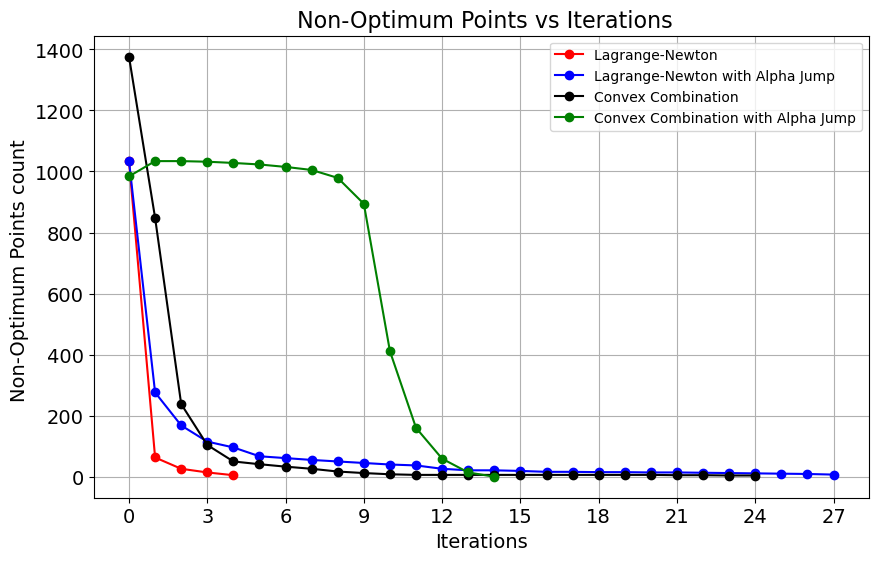

In [12]:
import csv
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Function to read data from CSV
def read_csv(filename):
    iterations = []
    non_opts = []
    with open(filename, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader)  # Skip header row
        for row in csvreader:
           iterations.append(int(row[0]))
           non_opts.append(float(row[1]))
    return iterations, non_opts

# Read data from the first CSV file
iterations1, non_opts1 = read_csv('Non_opt_pnts.csv')
iterations2, non_opts2 = read_csv('Non_opt_pnts_alpha12.csv')
iterations3, non_opts3 = read_csv('Non_opt_pnts_REF_10xy.csv')
iterations4, non_opts4 = read_csv('Non_opt_pnts_REF_alpha12_convex_comb.csv')



#Sort data
sorted_data1 = sorted(zip(iterations1, non_opts1))
iterations1, non_opts1  = zip(*sorted_data1)

sorted_data2 = sorted(zip(iterations2, non_opts2))
iterations2, non_opts2  = zip(*sorted_data2)

sorted_data3 = sorted(zip(iterations3, non_opts3))
iterations3, non_opts3  = zip(*sorted_data3)

sorted_data4 = sorted(zip(iterations4, non_opts4))
iterations4, non_opts4  = zip(*sorted_data4)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(iterations1, non_opts1 , marker='o', linestyle='-', color='r', label='Lagrange-Newton ')
plt.plot(iterations2,  non_opts2 , marker='o', linestyle='-', color='b', label='Lagrange-Newton with Alpha Jump')
plt.plot(iterations3,  non_opts3 , marker='o', linestyle='-', color='k', label='Convex Combination ')
plt.plot(iterations4,  non_opts4 , marker='o', linestyle='-', color='g', label='Convex Combination with Alpha Jump')

# plt.plot(iterations2, nonoptimal_points2, marker='s', linestyle='--', color='r', label='xy')
# plt.plot(iterations3, nonoptimal_points3, marker='*', linestyle=':', color='m', label='10xy with alpha12 jump')
# plt.plot(iterations4, nonoptimal_points4, marker='x', linestyle='-', color='m', label='10xy with projected grad')
# plt.plot(iterations5, nonoptimal_points5, marker='o', linestyle='-', color='k', label='10xy,alpha12(2,7) with projected grad')



# Add titles and labels
plt.title(' Non-Optimum Points vs Iterations',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('Iterations',fontsize=14)
plt.ylabel('Non-Optimum Points count ',fontsize=14)

# Show the legend
plt.legend()

# Show the grid
plt.grid(True)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.savefig("NonOptimalPoints.png")
# Display the plot
plt.show()
